In [4]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
include("hmc_mod.jl")
include("helper_functions.jl")
include("rj_proposals.jl")
include("NUTS.jl");

In [147]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
network = "classifier"
#network = "interpolator"

#Data hyperparameters
n = 500 #Number of samples per mode (classifier)
m = 4 #Number of modes (classifier)
d = 2 #Input dimension
N = n*m #Total samples
σₐ = 2.0 #Mode variance (classifier)
bound = 3.0

σ₁ = 3.0#1/τ₁
σ₂ = 3.0#1/τ₂
σ₃ = 30.0#1/τ₃

#Network hyperparameters
α = 6 #Gamma Scale for Hyperparameters

#Node hyperparameters
k_range = 4 #Maximum number of neurons per layer
k_list = [Int(i) for i in 1:k_range]
k_real = 2

#Layer hyperparameters
l_range = 4 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_list = zeros(l_range)
l_list[l_range] = 1.0
l_real = 4

#NUTS
Δmax = 1000;

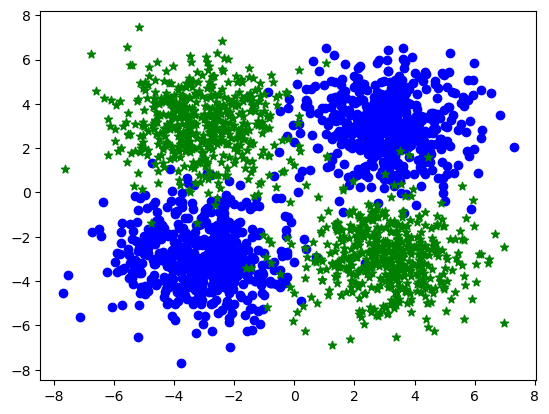

(2, 2000)

In [148]:
#Data
x_raw, classes = real_data_classifier(Int(N/4), 4, bound, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]
y_real = classes

plot_data_classifier(x_raw,classes)
x = transpose(x_raw)
size(x)

In [152]:
#Bayesian Neural Net
function G(x, trace)
    activation = σ
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], 1, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

@gen function classifier(x::Array{Float64})
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    #α = 0.001 #Gamma Scale for Hyperparameters
    
    #ω₁ = 100
    #ω₂ = (sum([obs[(:k,i)] for i=1:l]))*10 #Neal (1996): Scaling relationship to # of hidden units
    #τ₁ ~ gamma(ω₁,α) #Hidden Weights
    #τ₂ ~ gamma(ω₁,α) #Hidden Biases
    #τ₃ ~ gamma(ω₂,α) #Output Weights
    #τᵧ ~ gamma(ωᵧ,α) #Noise Parameter for y
    #τ₄ ~ gamma() #Output Biases - Neal uses fixed sigmas here
    
    #Standard Deviations
    σ₁ = 300.0#1/τ₁
    σ₂ = 300.0#1/τ₂
    σ₃ = 3000.0#1/τ₃
    
    #Sample weight and parameter vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]
    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            μ = zeros(h)
            Σ = Diagonal([σ₁ for i=1:length(μ)])
            W[i] = @trace(mvnormal(μ,Σ), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            μ2 = zeros(k[i])
            Σ2 = Diagonal([σ₂ for i=1:length(μ2)])
            b[i] = @trace(mvnormal(μ2,Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            μₒ = zeros(k[l])
            Σₒ = Diagonal([σ₁ for i=1:length(μₒ)])
            W[i] = @trace(mvnormal(μₒ,Σₒ), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            μ2ₒ = zeros(1)
            Σ2ₒ = Diagonal([σ₁ for i=1:length(μ2ₒ)])
            b[i] = @trace(mvnormal(μ2ₒ,Σ2ₒ), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    y = scores
    for j=1:N
        y[j] = @trace(categorical([1-scores[j],scores[j]]), (:y,j))
    end
    #y = [(@trace(categorical([1-scores[j],scores[j]]), (:y,j))) for j=1:length(scores)]

    return scores
    
end;
obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs = obs_master;
@time (best_trace,) = generate(classifier, (x,), obs)

test_scores = classifier(x)
test_labels = data_labeller(test_scores)
test_acc = sum([classes[i] == test_labels[i] for i=1:length(classes)])

  0.438431 seconds (1.03 M allocations: 51.177 MiB)


1000

In [144]:
@time [obs_master[(:y,i)] = classes[i] for i=1:length(classes)]

  0.066295 seconds (53.46 k allocations: 2.735 MiB)


200-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

In [146]:
#-----------------------------------------
#Register Observed Data - Test Likelihood
#-----------------------------------------
obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    @time obs_master[(:y,i)] = classes[i]
end
obs = obs_master;

scores = []
accs = []
ks = []
best_ks = []
best_traces = []
(best_trace,) = generate(classifier, (x,), obs)
best_acc = 0
best_score = get_score(best_trace)
best_pred_y = (G(x, best_trace))
best_pred_labels = data_labeller(best_pred_y)
best_k = best_trace[(:k,1)]
while best_acc <= 100
    (best_trace,) = generate(classifier, (x,), obs)
    best_score = get_score(best_trace)
    best_k = best_trace[(:k,1)]
    best_pred_y = (G(x, best_trace))
    best_pred_labels = data_labeller(best_pred_y)
    #best_pred_y = [best_trace[(:y,i)] for i=1:length(classes)]
    best_acc = sum([classes[i] == best_pred_labels[i] for i=1:length(classes)])
end;
#println(best_trace[:τ₁])
#println(best_trace[:τ₂])
#println(best_trace[:τ₃])
#println(best_trace[:τᵧ])

println(best_acc)
println(get_score(best_trace))

  0.000009 seconds (3 allocations: 64 bytes)
  0.000008 seconds (3 allocations: 64 bytes)
  0.000003 seconds (3 allocations: 64 bytes)
  0.000011 seconds (3 allocations: 64 bytes)
  0.000001 seconds (3 allocations: 64 bytes)
  0.000001 seconds (3 allocations: 64 bytes)
  0.000001 seconds (3 allocations: 64 bytes)
  0.000001 seconds (3 allocations: 64 bytes)
  0.000001 seconds (3 allocations: 64 bytes)
  0.000002 seconds (3 allocations: 64 bytes)
  0.000005 seconds (6 allocations: 1.438 KiB)
  0.000001 seconds (3 allocations: 64 bytes)
  0.000001 seconds (3 allocations: 64 bytes)
  0.000002 seconds (3 allocations: 64 bytes)
  0.000001 seconds (3 allocations: 64 bytes)
  0.000001 seconds (3 allocations: 64 bytes)
  0.000001 seconds (3 allocations: 64 bytes)
  0.000001 seconds (3 allocations: 64 bytes)
  0.000002 seconds (3 allocations: 64 bytes)
  0.000001 seconds (3 allocations: 64 bytes)
  0.000001 seconds (3 allocations: 64 bytes)
  0.000001 seconds (3 allocations: 64 bytes)
  0.00000

117
-Inf


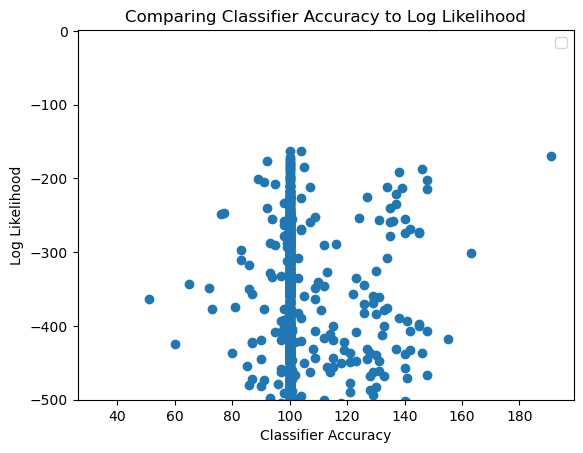

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7f9427bb1290>

In [82]:
#----------------
#Test Likelihood
#----------------
scores = []
accs = []
ks = []
best_ks = []
best_traces = []
function likelihood(best_trace, best_acc, best_score, best_k)
    obs = obs_master;
    #obs[(:k,1)] = 2
    (trace,) = generate(classifier, (x,), obs)
    
    pred_y = (G(x, trace))
    pred_labels = data_labeller(pred_y)
    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    
    #pred_y = [trace[(:y,i)] for i=1:length(classes)]
    #acc = sum([classes[i] == pred_y[i] for i=1:length(classes)])
    score = get_score(trace)
    #(score, retval) = assess(lh, (x,trace), obs_master)
    
    #println(score)
    if acc > best_acc
        best_acc = acc
        best_score = score
        best_trace = trace
        best_pred_y = pred_y
        best_k = best_trace[(:k,1)]
    end
    push!(best_ks,best_k)
    push!(scores,score)
    push!(accs,acc)
    #push!(ls, l)
    #println(best_score)
    return(best_trace, best_acc, best_score, best_k)
end;

for i=1:10000
    best_trace, best_acc, best_score, best_k = likelihood(best_trace, best_acc, best_score, best_k)
    push!(best_ks, best_k)
end

PyPlot.scatter(accs, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood")
plt.ylim(-500,1)
plt.legend()
#print(best_ks)

In [85]:
#--------------------
#RJMCMC - using NUTS
#--------------------
traces = []
scores = []
scores2 = []
acc = []
acc_a = []
acc_w = []
acc_l = []
k_results = []
epss = []
aL = 20
wL = 1

function within_move(trace, iters, obs, prev_trace)
    eps = uniform(0.01,0.04)
    selection = select_selection(trace)
    (new_trace, hmc_score) = NUTS(trace, selection, false, obs, iters, iters, prev_trace)
    score2 = get_score(new_trace)
    score1 = get_score(prev_trace)
    score = score2 - score1
    if score == 0.0
        accepted = 0.0
    elseif rand(Uniform(0,1)) < exp(score)
        trace = new_trace
        accepted = 1.0
        #println("Accepted")
    else
        trace = prev_trace
        accepted = 0.0
        #println("Not Accepted")
    end
    #push!(traces, trace)
    push!(acc, accepted)
    push!(acc_w, accepted)
    #accepted && println("Within accepted")
    return trace
end

function node_move(trace, iters, obs, prev_trace)
    
    #Determine birth or death
    current_l = trace[:l]
    layer = rand((1:current_l))
    current_k = trace[(:k, layer)]
    
    if current_k == last(k_list)
        move_type = 0
    elseif current_k == k_list[1]
        move_type = 1
    else
        move_type = bernoulli(0.5)
    end
    move = "Empty"
    
    obs_master = choicemap()::ChoiceMap
    for i=1:length(classes)
        obs_master[(:y,i)] = classes[i]
    end
    
    eps = rand(Uniform(0.1,0.4))

    #HMC Move 1
    selection = select_selection(trace)
    hmc1_trace = trace
    (hmc1_trace, hmc1_score) = NUTS(hmc1_trace, selection, false, obs, iters, iters, prev_trace)

    #RJ Move
    if move_type == 1
        move = "Birth"
        rj_trace = node_birth(hmc1_trace, layer)
    else
        move = "Death"
        rj_trace = node_death(hmc1_trace, layer)
    end

    #HMC Move 2
    hmc2_trace = rj_trace
    (hmc2_trace, hmc2_score) = NUTS(hmc2_trace, selection, false, obs, iters, iters, hmc2_trace)

    #(score1,) = assess(lh, (x, trace), obs_master)
    #(score2,) = assess(lh, (x, hmc2_trace), obs_master)
    score1 = get_score(prev_trace)
    score2 = get_score(hmc2_trace)
    logscore = (score2 - score1)
    score = exp(logscore) #+ hmc1_score - hmc2_score)
    #println("$move: $score")
    
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = hmc2_trace
        new_k = [trace[(:k,i)] for i=1:trace[:l]]
        println("New ks accepted! Current ks: $(new_k)")
    else
        #println("Sticking with the old k!")
        accepted = false
        trace = prev_trace
    end

    #println("$move Old Trace: $score1; Pre-HMC: $score_test; Post-HMC: $score2")
        
    #push!(traces, trace)
    push!(acc, accepted)
    push!(acc_a, accepted)
    push!(scores, score)
    return trace
end


function rjmcmc(starting_trace, iters)
    trace = starting_trace
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:trace[:l]]
    println("Beginning RJMCMC")
    println("Starting ks: $ks")
    println("--------------------------------")

    for i=1:iters
        l = trace[:l]
        ks = [trace[(:k,i)] for i=1:trace[:l]]
        #obs_master = choicemap()::ChoiceMap
        #for i=1:length(classes)
            #obs_master[(:y,i)] = classes[i]
        #end
        obs = obs_master;
        if i%20 == 0
            #println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
            println("Epoch $i layer count: $l, ks: $ks")
            println("Epoch $i Within Acceptance Prob: $(sum(acc_w)/length(acc_w))")
            println("Epoch $i Across Acceptance Prob: $(sum(acc_a)/length(acc_a))")
            #println("Epoch $i Layer Acceptance Prob: $(sum(acc_l)/length(acc_l))")
            #println([trace[(:k,i)] for i=1:trace[:l]])
        end
        
        #Gibbs sampling for hyperparameters
        prev_trace = trace
        #trace, obs = select_hyperparameters(prev_trace, obs)
        
        #Indicator variable for move type
        u = rand(Uniform(0,1))
        if u > 0.9
            (trace) = node_move(trace, 2, obs, prev_trace)
        else
            (trace) = within_move(trace, 1, obs, prev_trace)
        end
        push!(traces, trace)
        push!(scores, get_score(trace))
        push!(k_results, trace[(:k,1)])
    end
    println("Finished")
end
 
runs = 2000

obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs = obs_master
obs[:l] = 1
#(starting_trace,) = generate(classifier, (x,), obs)
starting_trace = best_trace
#obs[:l] = starting_trace[:l]

include("NUTS.jl");
rjmcmc(starting_trace,runs);

Beginning RJMCMC
Starting ks: [2, 4]
--------------------------------
Epoch 20 layer count: 2, ks: [2, 4]
Epoch 20 Within Acceptance Prob: 0.35294117647058826
Epoch 20 Across Acceptance Prob: 0.0
Epoch 40 layer count: 2, ks: [2, 4]
Epoch 40 Within Acceptance Prob: 0.3055555555555556
Epoch 40 Across Acceptance Prob: 0.0
New ks accepted! Current ks: [2, 3]
Epoch 60 layer count: 2, ks: [2, 3]
Epoch 60 Within Acceptance Prob: 0.2962962962962963
Epoch 60 Across Acceptance Prob: 0.2
Epoch 80 layer count: 2, ks: [2, 3]
Epoch 80 Within Acceptance Prob: 0.2916666666666667
Epoch 80 Across Acceptance Prob: 0.14285714285714285
Epoch 100 layer count: 2, ks: [2, 3]
Epoch 100 Within Acceptance Prob: 0.2777777777777778
Epoch 100 Across Acceptance Prob: 0.1111111111111111
Epoch 120 layer count: 2, ks: [2, 3]
Epoch 120 Within Acceptance Prob: 0.25925925925925924
Epoch 120 Across Acceptance Prob: 0.09090909090909091
Epoch 140 layer count: 2, ks: [2, 3]
Epoch 140 Within Acceptance Prob: 0.2539682539682539

InterruptException: InterruptException:

In [86]:
println(traces[40][(:W,1)])
println(traces[50][(:W,1)])

[-25.327756114805418, 4.36009425284407, 2.945717437799953, 35.29416389572463]
[-24.319684361093703, 2.1023409849137065, -2.132365762453545, 35.93041736122491]


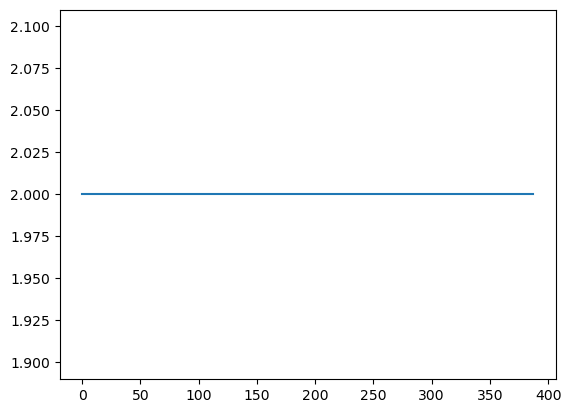

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f942791b910>

In [87]:
plot(k_results)

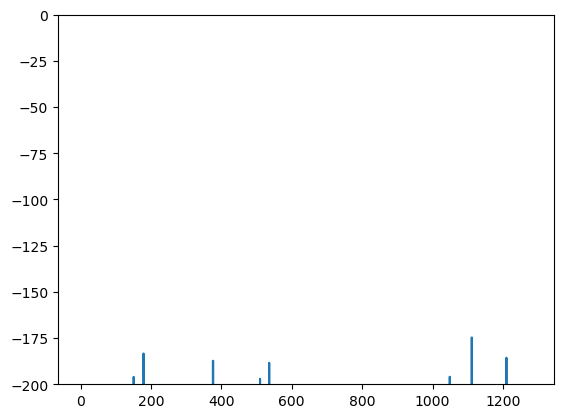

(-200.0, 0.0)

In [103]:
scores = [get_score(trace) for trace in traces]
plot(scores)
plt.ylim(-200,0)

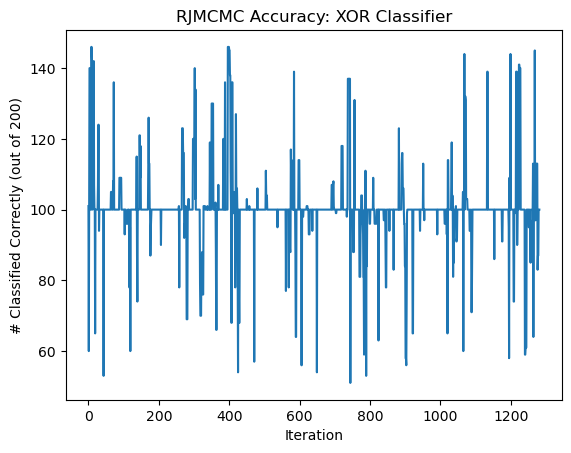

100.34009360374415


In [104]:
accs = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = G(x,trace)
    pred_labels = data_labeller(pred_y)
    
    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    push!(accs,acc)
end

plot(accs)
println(sum(accs)/length(accs))
plt.title("RJMCMC Accuracy: XOR Classifier")
plt.xlabel("Iteration")
plt.ylabel("# Classified Correctly (out of 200)");

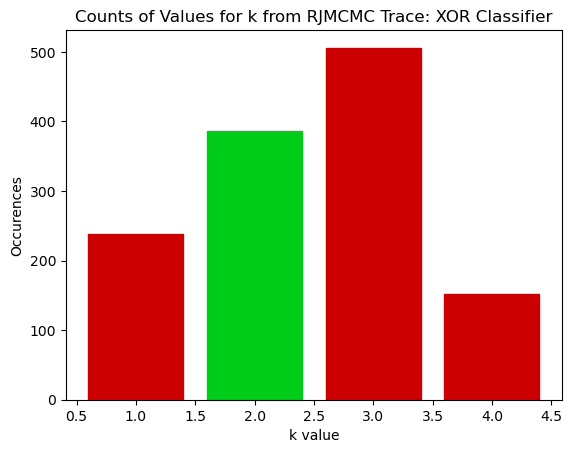

In [105]:
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([k_results[i] == j for i in 1:length(k_results)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[2].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace: XOR Classifier")
plt.xlabel("k value")
plt.ylabel("Occurences");

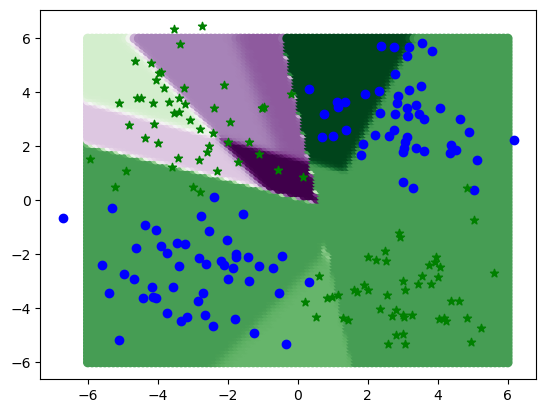

In [106]:
function plot_grid(data,scores,alpha=1.0)
    PyPlot.scatter(data[:,1],data[:,2],c=scores,alpha=alpha,cmap="PRGn")
    #PyPlot.colorbar()
end

function tracegrid(traces, samples=500, low=-6.0, high=6.0)
    d=2
    n=100
    r = range(low, high, length = n)
    
    iter = Iterators.product((r for _ in 1:d)...)
    grid= vec([collect(i) for i in iter])
    grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
    grid2 = transpose(grid_raw)
    z_master = zeros(length(grid2[1,:]))
    
    for i=1:samples
        j = rand((100,length(traces)))
        trace = traces[j]
        z = Flux.σ.(G(grid2,trace))[1,:]
        z_master += (z ./ samples)
    end
    plot_grid(grid_raw, z_master)
end

tracegrid(traces)
plot_data_classifier(x_raw,classes)

In [102]:
#-------------------------
#RJMCMC - Layers and Nodes
#OLD HMC BASED ALGORITHM
#-------------------------
traces = []
scores = []
scores2 = []
acc = []
acc_a = []
acc_w = []
acc_l = []
k_results = []
epss = []
aL = 20
wL = 10
eps = 0.5

function within_move(trace, iters, obs, prev_trace)
    for i=1:iters
        #eps = 0.5
        selection = select_selection(trace)
        (new_trace, hmc_score) = hmc_mod(trace, prev_trace, selection, L=wL, eps=eps, check=false, observations=obs)
        score1 = get_score(prev_trace)
        score2 = get_score(new_trace)
        logscore = (score2 - score1)
        score = exp(logscore)
        if rand(Uniform(0,1)) < exp(score)
            trace = new_trace
            accepted = true
        else
            accepted = false
        end
        push!(traces, trace)
        push!(acc, accepted)
        push!(acc_w, accepted)
        #accepted && println("Within accepted")
    end
    return trace
end

function node_move(trace, iters, obs, prev_trace)
    
    #Determine birth or death
    current_l = trace[:l]
    layer = rand((1:current_l))
    current_k = trace[(:k, layer)]
    
    if current_k == last(k_list)
        move_type = 0
    elseif current_k == k_list[1]
        move_type = 1
    else
        move_type = bernoulli(0.5)
    end
    move = "Empty"
    
    #obs_master = choicemap()::ChoiceMap
    #for i=1:length(classes)
        #obs_master[(:y,i)] = classes[i]
    #end

    #HMC Move 1
    selection = select_selection(trace)
    hmc1_trace = trace
    (hmc1_trace, hmc1_score) = hmc_mod(hmc1_trace, prev_trace, selection, L=aL, eps=eps, check=true, observations=obs)

    #RJ Move
    if move_type == 1
        move = "Birth"
        rj_trace = node_birth(hmc1_trace, layer)
    else
        move = "Death"
        rj_trace = node_death(hmc1_trace, layer)
    end

    #HMC Move 2
    hmc2_trace = rj_trace
    (hmc2_trace, hmc2_score) = hmc_mod(hmc2_trace, rj_trace, selection, L=aL, eps=eps, check=true, observations=obs)

    score1 = get_score(prev_trace)
    score2 = get_score(hmc2_trace)
    logscore = (score2 - score1)
    score = exp(logscore) #* exp(hmc1_score) * exp(-hmc2_score)
    #println("$move: $score")
    
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = hmc2_trace
        new_k = [trace[(:k,i)] for i=1:trace[:l]]
        #println("New ks accepted! Current ks: $(new_k)")
    else
        #println("Sticking with the old k!")
        accepted = false
    end

    #println("$move Old Trace: $score1; Pre-HMC: $score_test; Post-HMC: $score2")
        
    push!(traces, trace)
    push!(acc, accepted)
    push!(acc_a, accepted)
    push!(scores, score)
    push!(scores2, logscore)
    return trace
end


function rjmcmc(starting_trace, iters)
    trace = starting_trace
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:trace[:l]]
    println("Beginning RJMCMC")
    println("Starting ks: $ks")
    println("--------------------------------")
    #@showprogress 1 "Sampling..." for i = 1:iters
    for i=1:iters
        l = trace[:l]
        ks = [trace[(:k,i)] for i=1:trace[:l]]
        #obs_master = choicemap()::ChoiceMap
        #for i=1:length(classes)
            #obs_master[(:y,i)] = classes[i]
        #end
        obs = obs_master;
        if i%25 == 0
            #println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
            println("Epoch $i layer count: $l, ks: $ks")
            println("Epoch $i Within Acceptance Prob: $(sum(acc_w)/length(acc_w))")
            println("Epoch $i Across Acceptance Prob: $(sum(acc_a)/length(acc_a))")
            #println("Epoch $i Layer Acceptance Prob: $(sum(acc_l)/length(acc_l))")
            println([trace[(:k,i)] for i=1:trace[:l]])
        end
        
        #Gibbs sampling for hyperparameters
        prev_trace = trace
        #trace, obs = select_hyperparameters(trace, obs)
        
        #Indicator variable for move type
        u = rand(Uniform(0,1))
        if u > 0.5
            (trace) = node_move(trace, 1, obs, prev_trace)
        else
            (trace) = within_move(trace, 1, obs, prev_trace)
        end
        push!(scores, get_score(trace))
        push!(k_results, trace[(:k,1)])
    end
    println("Finished")
end
 
runs = 20000
#starting_trace = best_trace

obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs = obs_master
obs[:l] = 1
#(starting_trace,) = generate(classifier, (x,), obs)
starting_trace = best_trace
obs[:l] = starting_trace[:l]

rjmcmc(starting_trace,runs);

Beginning RJMCMC
Starting ks: [2, 4]
--------------------------------
Epoch 25 layer count: 2, ks: [3, 3]
Epoch 25 Within Acceptance Prob: 0.9285714285714286
Epoch 25 Across Acceptance Prob: 0.6
[3, 3]
Epoch 50 layer count: 2, ks: [1, 2]
Epoch 50 Within Acceptance Prob: 0.9642857142857143
Epoch 50 Across Acceptance Prob: 0.6190476190476191
[1, 2]
Epoch 75 layer count: 2, ks: [3, 1]
Epoch 75 Within Acceptance Prob: 0.9743589743589743
Epoch 75 Across Acceptance Prob: 0.5142857142857142
[3, 1]
Epoch 100 layer count: 2, ks: [3, 2]
Epoch 100 Within Acceptance Prob: 0.9791666666666666
Epoch 100 Across Acceptance Prob: 0.37254901960784315
[3, 2]
Epoch 125 layer count: 2, ks: [3, 3]
Epoch 125 Within Acceptance Prob: 0.9821428571428571
Epoch 125 Across Acceptance Prob: 0.4117647058823529
[3, 3]
Epoch 150 layer count: 2, ks: [3, 2]
Epoch 150 Within Acceptance Prob: 0.9859154929577465
Epoch 150 Across Acceptance Prob: 0.3974358974358974
[3, 2]
Epoch 175 layer count: 2, ks: [2, 2]
Epoch 175 Within

InterruptException: InterruptException:

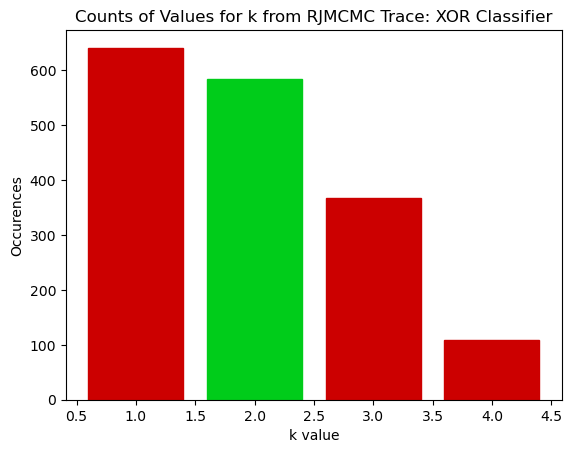

In [96]:
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([k_results[i] == j for i in 1:length(k_results)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[2].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace: XOR Classifier")
plt.xlabel("k value")
plt.ylabel("Occurences");